In [1]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pylab import rcParams

import seaborn as sns

from StockDataSource import YahooDataSource
from StockPricePredictor import StockPricePredictor
import Utils

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 18,8

In [3]:
yahoo = YahooDataSource()

start = datetime(1900, 1, 4)
end = datetime.today()

gold = yahoo.get_ticker('GLD', start, end)
gold.name = 'GLD'
gold.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2004-11-18,44.430000,44.490002,44.070000,44.380001,5992000,44.380001
2004-11-19,44.490002,44.919998,44.470001,44.779999,11655300,44.779999
2004-11-22,44.750000,44.970001,44.740002,44.950001,11996000,44.950001
2004-11-23,44.880001,44.919998,44.720001,44.750000,3169200,44.750000
2004-11-24,44.930000,45.049999,44.790001,45.049999,6105100,45.049999


In [4]:
def show_plot(ticker):
    ticker['Adj Close'].plot(color='g', linewidth=0.5)
    plt.plot(pd.rolling_mean(ticker['Adj Close'], window=252), linewidth=0.5, color='b')
    max_close = ticker['Adj Close'].max()
    max_volume = ticker['Volume'].max()
    volume_norm = ticker['Volume'].apply(lambda x: (float(x)/max_volume)*max_close)
    #volume_norm.plot(alpha=0.5, color='b', linewidth=0.5)

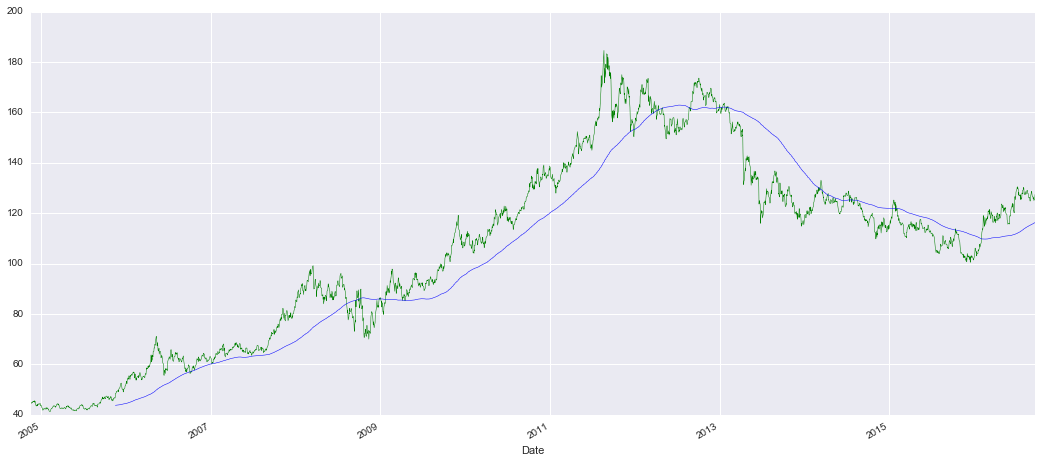

In [5]:
#show_plot(gold)
#gold['Adj Close'] = gold['Adj Close'] / gold['Adj Close'].ix[0, :]
show_plot(gold)

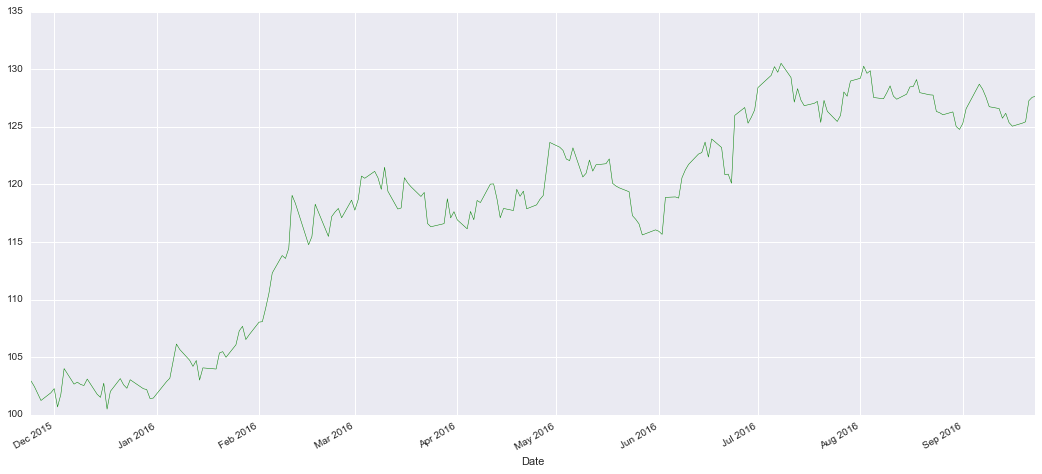

In [6]:
prediction_time = 7
gold_pred = gold.ix[-(prediction_time*30):]
show_plot(gold_pred)

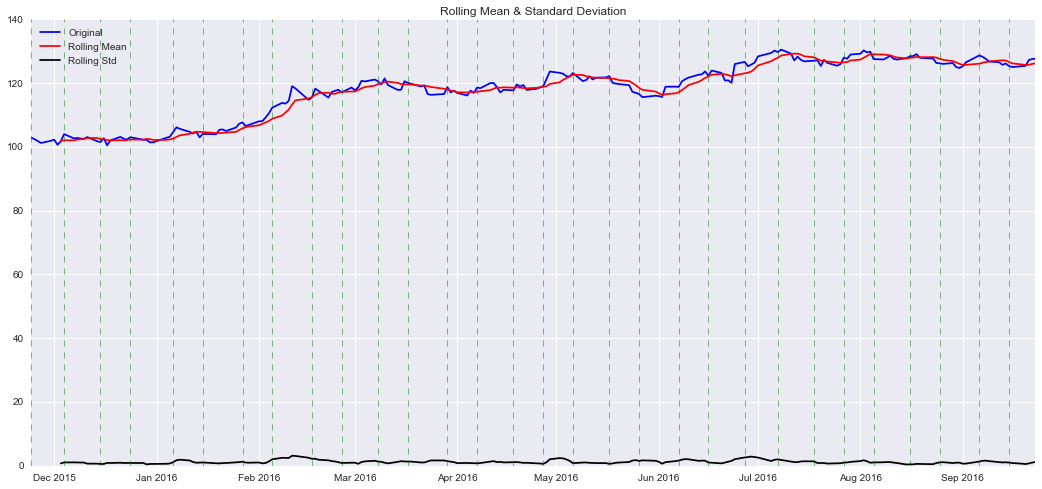

Results of Dickey-Fuller Test:
Test Statistic                  -1.451119
p-value                          0.557539
#Lags Used                       0.000000
Number of Observations Used    209.000000
Critical Value (5%)             -2.875471
Critical Value (1%)             -3.462032
Critical Value (10%)            -2.574195
dtype: float64


In [7]:
Utils.test_stationarity(gold_pred['Adj Close'], window=prediction_time)

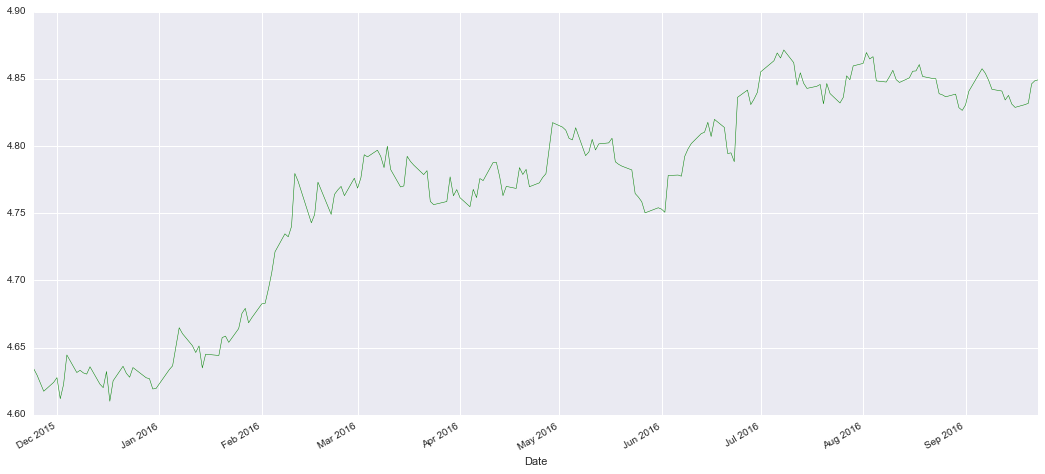

In [8]:
gold_log = gold_pred.copy()
gold_log['Adj Close'] = np.log(gold_log['Adj Close'])
gold_log['Adj Close Diff'] = gold['Adj Close'] - gold['Adj Close'].shift(1)
gold_log.dropna(inplace=True)
show_plot(gold_log)

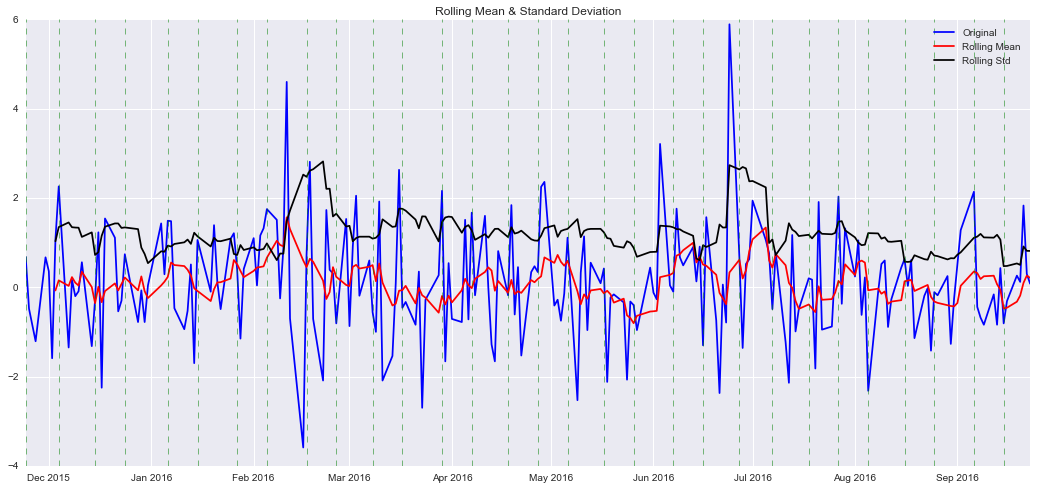

Results of Dickey-Fuller Test:
Test Statistic                -1.218004e+01
p-value                        1.358178e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (5%)           -2.875538e+00
Critical Value (1%)           -3.462186e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


In [9]:
Utils.test_stationarity(gold_log['Adj Close Diff'], window=prediction_time)

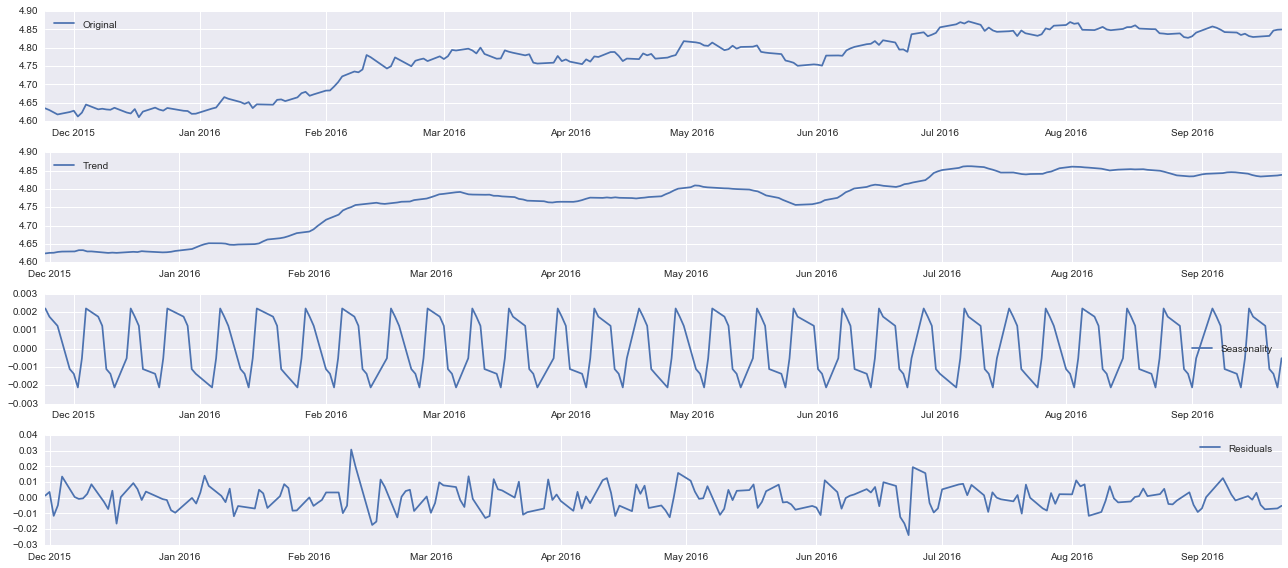

In [10]:
(trend, sesonal, residual) = Utils.decompose(gold_log['Adj Close'], freq=prediction_time)
res = residual.dropna()
Utils.plot_decomposition(gold_log['Adj Close'], trend, sesonal, res)

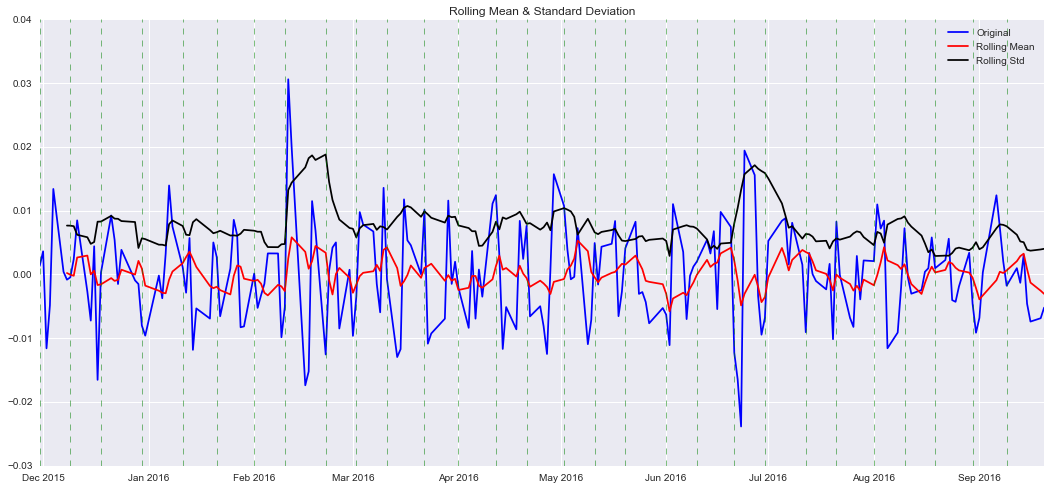

Results of Dickey-Fuller Test:
Test Statistic                -6.825637e+00
p-value                        1.951163e-09
#Lags Used                     1.200000e+01
Number of Observations Used    1.910000e+02
Critical Value (5%)           -2.876794e+00
Critical Value (1%)           -3.465059e+00
Critical Value (10%)          -2.574901e+00
dtype: float64


In [11]:
Utils.test_stationarity(res, window=prediction_time)

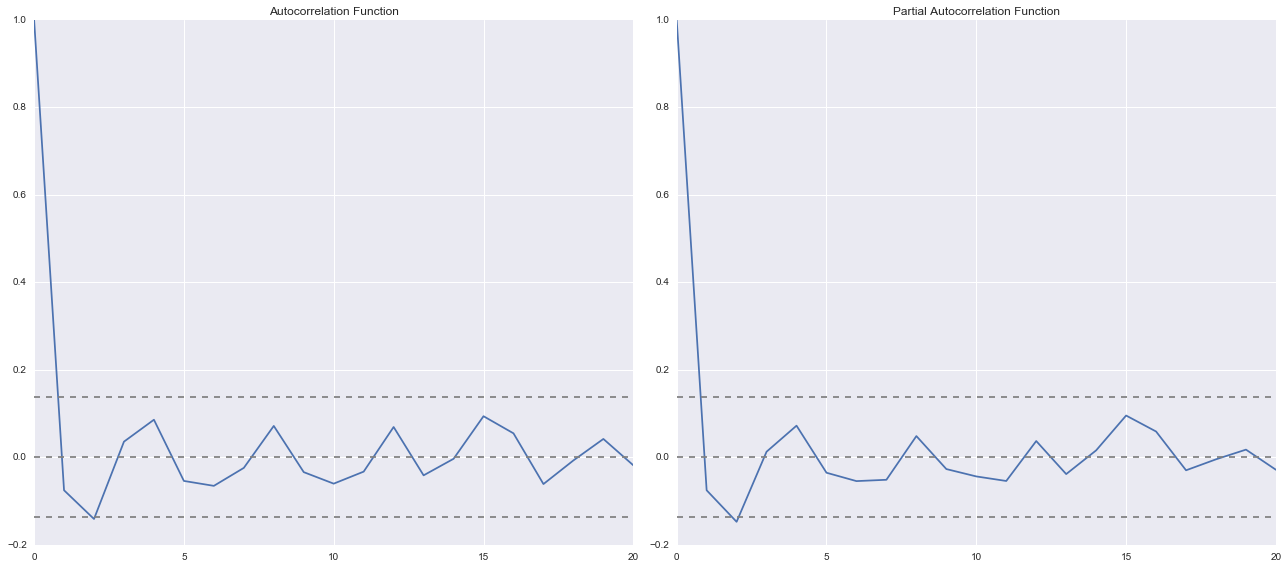

In [12]:
lag_acf = acf(gold_log['Adj Close Diff'], nlags=20)
lag_pacf = pacf(gold_log['Adj Close Diff'], nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

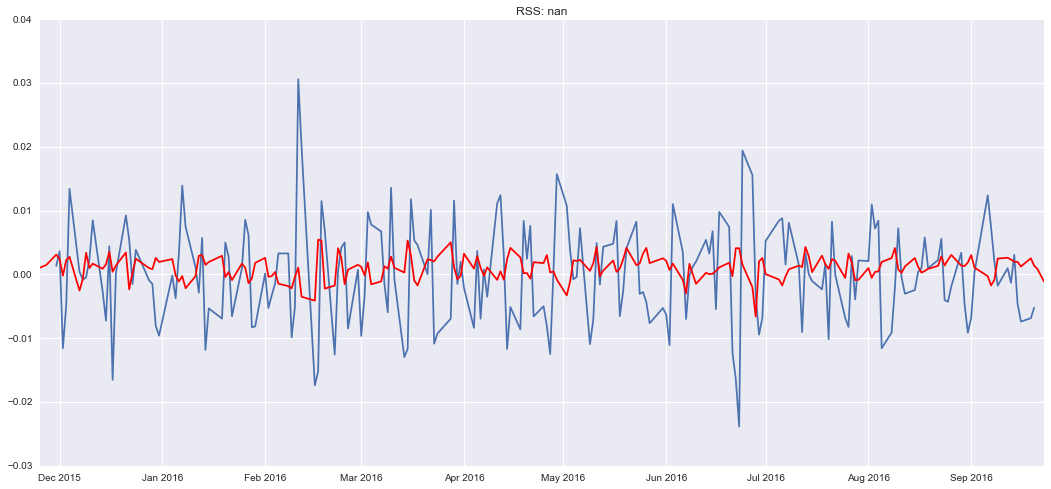

In [13]:
model = ARIMA(gold_log['Adj Close'], order=(2, 1, 1))
results_AR = model.fit(disp=-1)  
plt.plot(res)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-res)**2))

In [14]:
res2 = pd.Series(data=gold_log['Adj Close'].values.squeeze(), index=gold_log['Adj Close'].index)
print res2.head()

Date
2015-11-24    4.634146
2015-11-25    4.629472
2015-11-27    4.617593
2015-11-30    4.624188
2015-12-01    4.627714
dtype: float64


In [15]:
res3 = res2.reset_index(drop=True).values
print res3[-5:]

[ 4.83087047  4.83182757  4.84631079  4.84866523  4.84929216]


In [16]:
arima = ARIMA(res3, order=(2, 1, 1)).fit()
results = arima.predict(start=len(res3)-1, end=len(res3)+prediction_time, dynamic=True)
print results

[-0.00113256  0.00121291  0.00136121  0.00095876  0.00100554  0.00106193
  0.00104453  0.00103853  0.00104238]


In [17]:
predictions_ARIMA_diff = pd.Series(results, copy=True)
#predictions_ARIMA_diff = pd.Series(results, copy=True)
print predictions_ARIMA_diff.head()

0   -0.001133
1    0.001213
2    0.001361
3    0.000959
4    0.001006
dtype: float64


In [18]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

0   -0.001133
1    0.000080
2    0.001442
3    0.002400
4    0.003406
dtype: float64


In [19]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
start = gold_log['Adj Close'].index[-1]
end = start + pd.tseries.offsets.DateOffset(days=2*prediction_time)

In [20]:
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
index = pd.DatetimeIndex(start=start,end=end, freq=us_bd)

In [21]:
print predictions_ARIMA_diff_cumsum[-prediction_time:]

2    0.001442
3    0.002400
4    0.003406
5    0.004468
6    0.005512
7    0.006551
8    0.007593
dtype: float64


In [22]:
preds = predictions_ARIMA_diff_cumsum[-prediction_time:].values
dateIndex = index.values[0:prediction_time]
predictions_ARIMA_diff_date = pd.Series(data=preds, index=dateIndex)
print predictions_ARIMA_diff_date

2016-09-23    0.001442
2016-09-26    0.002400
2016-09-27    0.003406
2016-09-28    0.004468
2016-09-29    0.005512
2016-09-30    0.006551
2016-10-03    0.007593
dtype: float64


In [23]:
print gold_log['Adj Close'].tail(20)
lastValuePred = pd.Series(gold_log['Adj Close'].ix[-1], index=dateIndex)
print "\nlast\n", lastValuePred
print "\npredictions\n", predictions_ARIMA_diff_date
predicted = lastValuePred.add(predictions_ARIMA_diff_date, fill_value=0)
print "\npredicted\n", predicted

Date
2016-08-26    4.836679
2016-08-29    4.838660
2016-08-30    4.828554
2016-08-31    4.826552
2016-09-01    4.830631
2016-09-02    4.840796
2016-09-06    4.857562
2016-09-07    4.854137
2016-09-08    4.848822
2016-09-09    4.842217
2016-09-12    4.840953
2016-09-13    4.834296
2016-09-14    4.837709
2016-09-15    4.831269
2016-09-16    4.828794
2016-09-19    4.830870
2016-09-20    4.831828
2016-09-21    4.846311
2016-09-22    4.848665
2016-09-23    4.849292
Name: Adj Close, dtype: float64

last
2016-09-23    4.849292
2016-09-26    4.849292
2016-09-27    4.849292
2016-09-28    4.849292
2016-09-29    4.849292
2016-09-30    4.849292
2016-10-03    4.849292
dtype: float64

predictions
2016-09-23    0.001442
2016-09-26    0.002400
2016-09-27    0.003406
2016-09-28    0.004468
2016-09-29    0.005512
2016-09-30    0.006551
2016-10-03    0.007593
dtype: float64

predicted
2016-09-23    4.850734
2016-09-26    4.851692
2016-09-27    4.852698
2016-09-28    4.853760
2016-09-29    4.854804
2016-0

Date
2016-09-01    125.290001
2016-09-02    126.570000
2016-09-06    128.710007
2016-09-07    128.270004
2016-09-08    127.589996
2016-09-09    126.750000
2016-09-12    126.589996
2016-09-13    125.750000
2016-09-14    126.180000
2016-09-15    125.370003
2016-09-16    125.059998
2016-09-19    125.320000
2016-09-20    125.440002
2016-09-21    127.269997
2016-09-22    127.570000
2016-09-23    127.650002
Name: Adj Close, dtype: float64
2016-09-23    127.834150
2016-09-26    127.956771
2016-09-27    128.085502
2016-09-28    128.221591
2016-09-29    128.355593
2016-09-30    128.488964
2016-10-03    128.622967
dtype: float64


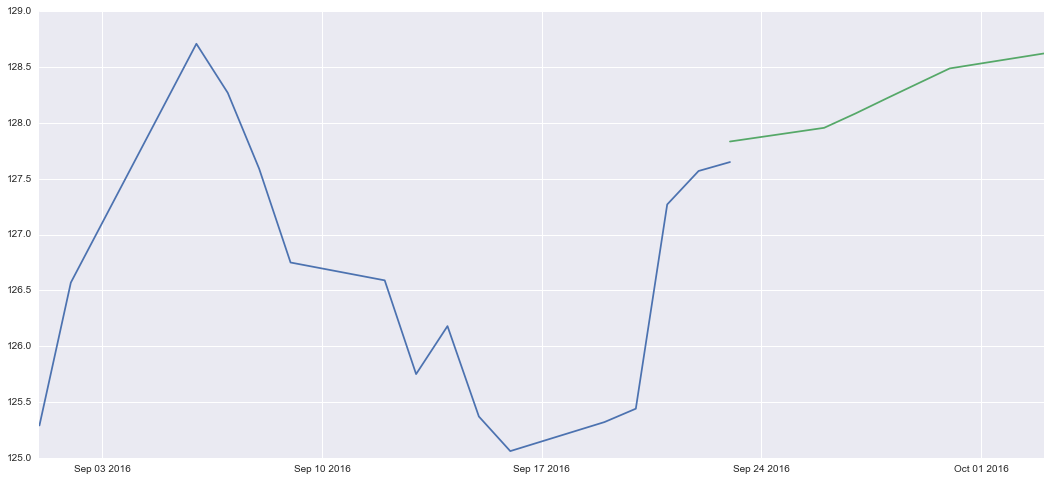

In [24]:
predictions = np.exp(predicted)
plt.plot(gold['Adj Close'].ix['2016-09-01':])
plt.plot(predictions)
print gold['Adj Close'].ix['2016-09-01':]
print predictions

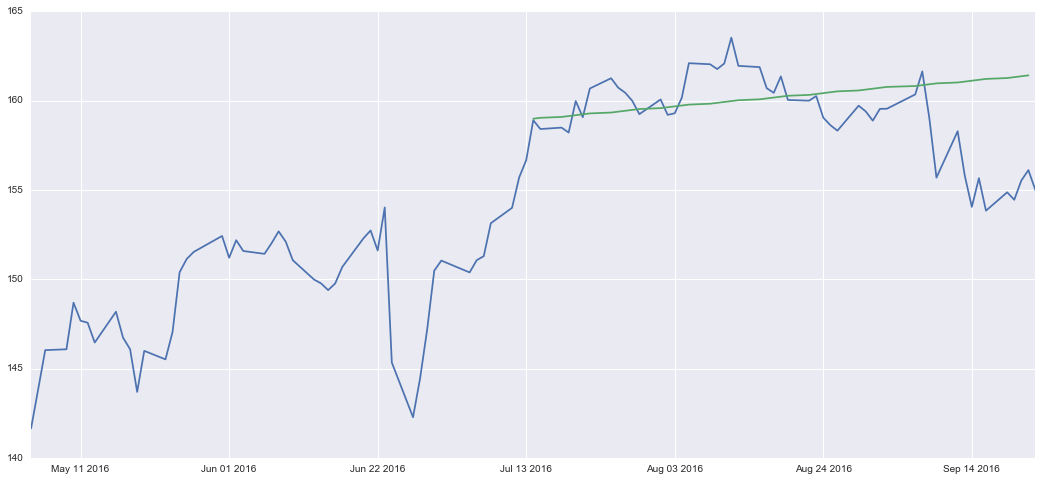

In [25]:
from arima import predictARIMA

start = datetime(1900, 1, 4)
end = datetime.today()

original = yahoo.get_ticker('IBM', start, end)['Adj Close']
prediction_days = 50
series = original.ix[0:-prediction_days]
predictions = predictARIMA(series, prediction_days)
plt.plot(original.ix[-2*prediction_days:])
plt.plot(predictions)